# Data Hackathon Description:

In 2016, GP practices in Northern Ireland wrote prescriptions for almost 29 million items. The number of items and their cost varied significantly, but using open data, we can help make predictions to aid budget planning.

The goal of this competition is to build a predictive model with historical data to accurately predict the prescription costs of GP practices. We will be predicting the average prescription spend per patient for each GP practice, each month.

# Importing Libraries:

This notebook is written in Python(3.5) on Ubuntu(16.04) and requires the following libraries:

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew 

from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Reading in and Merging the Training Data:

* competition_starter.csv - the initial training set
* competition_employment.csv - additional data with employment details
* competition_waiting.csv - additional data with specialist waiting list time details
* holdout.csv - the testing data to score your model on for submissions

In [2]:
# The file path to the folder containing all the datasets.
data_location = 'datasets/'

In [3]:
# Read in the starter dataset.
file_name = 'competition_starter.csv'
starter_data = pd.read_csv(data_location + file_name, header=0, index_col=0)

In [4]:
# Read in the employment dataset.
file_name_employment = 'competition_employment.csv'
employment_data = pd.read_csv(data_location + file_name_employment, header=0)

In [5]:
# Merge the starter and employment datasets based on the 'soa' column to form a new dataset.
common_key = 'soa'
hack_data = starter_data.merge(employment_data, on=common_key, how='left')

In [6]:
# Read in the waiting dataset.
file_name_waiting = 'competition_waiting.csv'
waiting_data = pd.read_csv(data_location + file_name_waiting)

In [7]:
# The newly created 'hack_data' dataset contains columns for 'gp_month' and 'gp_year'.
# The waiting dataset on the otherhand contains the column 'quarter_end'.
# The 'quarter_end' column can be easily broken up into 'gp_month' and 'gp_year'.
waiting_data['gp_month'] = [int(i.split('-')[0]) for i in waiting_data['quarter_end']]
waiting_data['gp_year'] = [int(i.split('-')[1]) for i in waiting_data['quarter_end']]

In [8]:
# The waiting dataset no longer requires the 'quarter_end' column. 
waiting_data = waiting_data.drop(['quarter_end'], 1)

In [9]:
# Merge the hack_data and waiting for datasets based now on the columns they share in common. 
common_key = ['hsc_trust', 'gp_month', 'gp_year']
hack_data = hack_data.merge(waiting_data, on=common_key, how='left')

In [10]:
# Read in the health dataset.
file_name_waiting = 'competition_health.csv'
health_data = pd.read_csv(data_location + file_name_waiting)

In [11]:
# Merge the hack_data and health datasets based on the 'soa' column.
common_key = 'soa'
hack_data = hack_data.merge(health_data, on=common_key, how='left')

In [12]:
# Read in the holdout dataset.
holdout = pd.read_csv(data_location + "holdout.csv", header=0, index_col=0)

In [13]:
# Check to see if holdout set shares the same columns as the hack_data dataset.
shared_col_names = np.intersect1d(np.asarray(list(holdout)), np.asarray(list(hack_data)))
holdout_list = [col for col in holdout.columns  if col not in shared_col_names]
holdout_list

['record_id', 'quarter_end']

In [14]:
# The 'quarter_end' column can be droped from the holdout dataset.
# While the 'record_id' column will be added the hack_data dataset. 
holdout = holdout.drop(['quarter_end'], 1)
hack_data['record_id'] = list(range(hack_data.shape[0]))

In [15]:
# The final training and testing datasets have now be created and will be renamed
# to 'train' and 'test' respectively for simplicity. 
train = hack_data
test = holdout

In [16]:
# Display the first five rows of the train dataset.
train.head(5)

,gp_practice,gp_year,gp_month,quality,eastings,northings,country,nhs_ha,longitude,latitude,...,thoracic_medicine,thoracic_surgery,urology,All_usual_residents,Very_good_health,Good_health,Fair_health,Bad_health,Very_bad_health,record_id
0,900207,2014,1,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,54.59872,...,NaN,NaN,NaN,2757.0,1255.0,922.0,410.0,138.0,32.0,0
1,900207,2014,2,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,54.59872,...,NaN,NaN,NaN,2757.0,1255.0,922.0,410.0,138.0,32.0,1
2,900207,2014,3,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,54.59872,...,1518.0,97.0,2153.0,2757.0,1255.0,922.0,410.0,138.0,32.0,2
3,900207,2014,4,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,54.59872,...,NaN,NaN,NaN,2757.0,1255.0,922.0,410.0,138.0,32.0,3
4,900207,2014,5,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,54.59872,...,NaN,NaN,NaN,2757.0,1255.0,922.0,410.0,138.0,32.0,4


In [17]:
# Display the first five rows of the test dataset.
test.head(5)

,record_id,gp_practice,gp_year,gp_month,quality,eastings,northings,country,nhs_ha,longitude,...,palliative_medicine,plastic_surgery,radiology,rehabilitation,restorative_dentistry,rheumatology,t_o_surgery,thoracic_medicine,thoracic_surgery,urology
0,0,900207,2017,6,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,...,13.0,100.0,0.0,48.0,1878.0,3241.0,23798.0,1733.0,55.0,3924.0
1,1,900207,2017,7,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,900207,2017,8,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,900209,2017,6,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,...,13.0,100.0,0.0,48.0,1878.0,3241.0,23798.0,1733.0,55.0,3924.0
4,4,900209,2017,7,1,336515,374326,Northern Ireland,Health & Social Care Board,-5.888459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Check for Outliers:

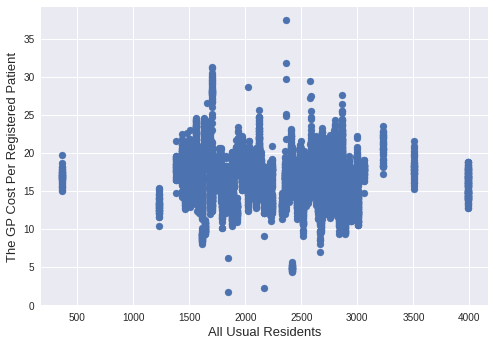

In [18]:
# A scatter plot to identify any clear outliers within the training dataset. 
fig, ax = plt.subplots()
ax.scatter(x = train['All_usual_residents'], y = train['gp_cost_per_registered_patient'])
plt.ylabel('The GP Cost Per Registered Patient', fontsize=13)
plt.xlabel('All Usual Residents', fontsize=13)
plt.show()

In [19]:
# Remove the outliers from the training dataset (was not used in final submission).
# train = train[(train['gp_cost_per_registered_patient']>7) & (train['gp_cost_per_registered_patient']<27)]

In [20]:
# Check the numbers of entries and columns within the training and testing datasets. 
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'record_id' column
train_ID = train['record_id']
test_ID = test['record_id']

# Now drop the 'record_id' colum since it is not required for the prediction stage.
train.drop("record_id", axis = 1, inplace = True)
test.drop("record_id", axis = 1, inplace = True)

# Check the data size after dropping the 'record_id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (9293, 200) 
The test data size before dropping Id feature is : (783, 199) 

The train data size after dropping Id feature is : (9293, 199) 
The test data size after dropping Id feature is : (783, 198) 


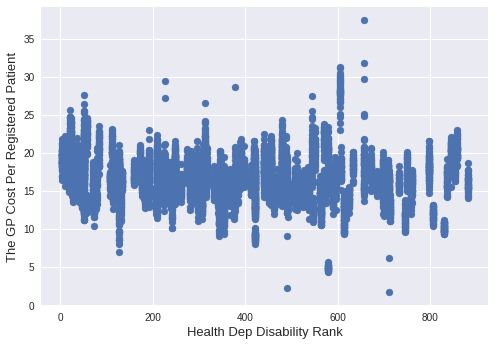

In [21]:
# A scatter plot to identify any clear outliers within the training dataset.
fig, ax = plt.subplots()
ax.scatter(x = train['health_dep_disability_rank'], y = train['gp_cost_per_registered_patient'])
plt.ylabel('The GP Cost Per Registered Patient', fontsize=13)
plt.xlabel('Health Dep Disability Rank', fontsize=13)
plt.show()

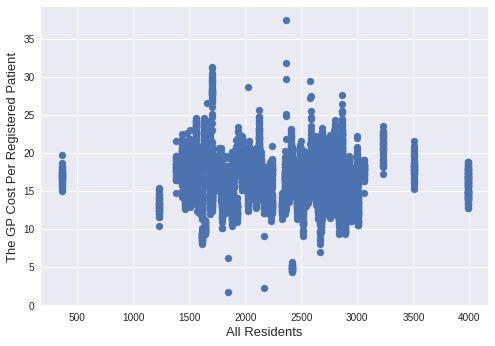

In [22]:
# A scatter plot to identify any clear outliers within the training dataset.
fig, ax = plt.subplots()
ax.scatter(x = train['all_residents'], y = train['gp_cost_per_registered_patient'])
plt.ylabel('The GP Cost Per Registered Patient', fontsize=13)
plt.xlabel('All Residents', fontsize=13)
plt.show()

# Check for Normality:


 mu = 16.68 and sigma = 2.92



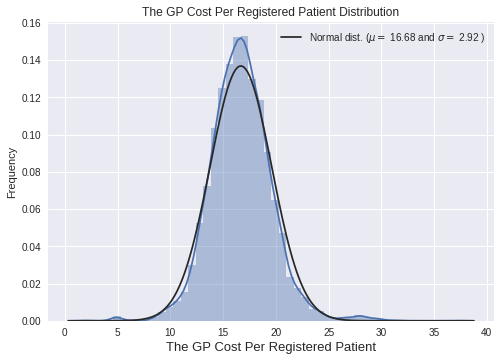

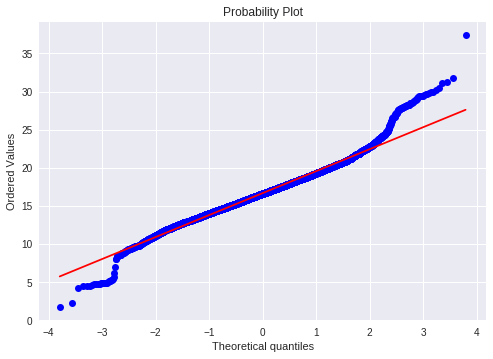

In [23]:
# Check for normality within the 'gp_cost_per_registered_patient' variable. 

sns.distplot(train['gp_cost_per_registered_patient'] , fit=norm);
plt.savefig("/home/mark/Pictures/qq_plot.png")

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['gp_cost_per_registered_patient'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution of the output variable. 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.xlabel('The GP Cost Per Registered Patient', fontsize=13)
plt.title('The GP Cost Per Registered Patient Distribution')

# Get also the QQ-plot of the output variable.
fig = plt.figure()
res = stats.probplot(train['gp_cost_per_registered_patient'], plot=plt)
plt.show()

In [24]:
# The 'gp_cost_per_registered_patient' variable as it stands appears to be normally distributed. 
# This is a good sign and therefore does not require any transformation function. 

# Check for Missing Values within the Data:

In [25]:
# Combine the training and testing datasets to check for missing values.
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.gp_cost_per_registered_patient.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['gp_cost_per_registered_patient'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (10076, 198)


In [26]:
# Create a 'missing_data' dataframe as a reference to all the columns containing missing values. 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
audiological,68.132195
general_surgery,68.132195
pain_management,68.132195
paediatric_surgery,68.132195
paediatric_neurology,68.132195
paediatric_dentistry,68.132195
general_medicine,68.132195
gastroenterology,68.132195
medical_oncology,68.132195
ent,68.132195


In [27]:
Counter(all_data_na.values.flatten())

Counter({5.1707026597856292: 1,
         11.790393013100436: 133,
         68.132195315601436: 45})

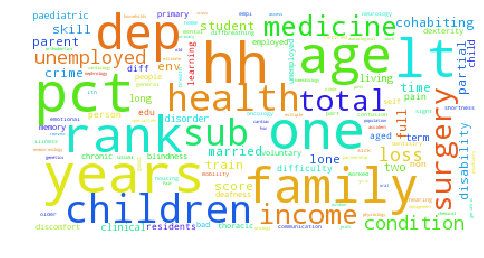

In [28]:
from wordcloud import WordCloud

common_missing_terms = [i for sublist in [col.split('_') for col in all_data_na.index] for i in sublist]

# Read the whole text.
text = ' '.join(common_missing_terms)

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=len(common_missing_terms),max_font_size=50, relative_scaling=0.25).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

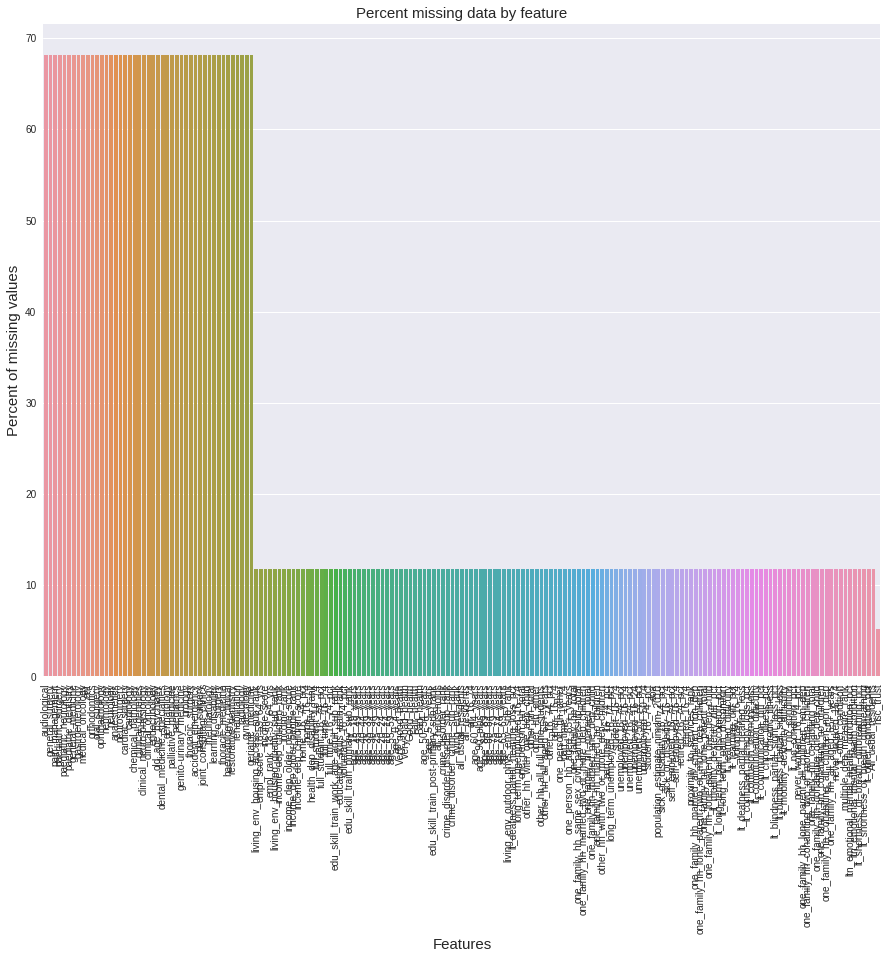

In [29]:
# Create a barplot for the 'missing_data' dataset. 
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

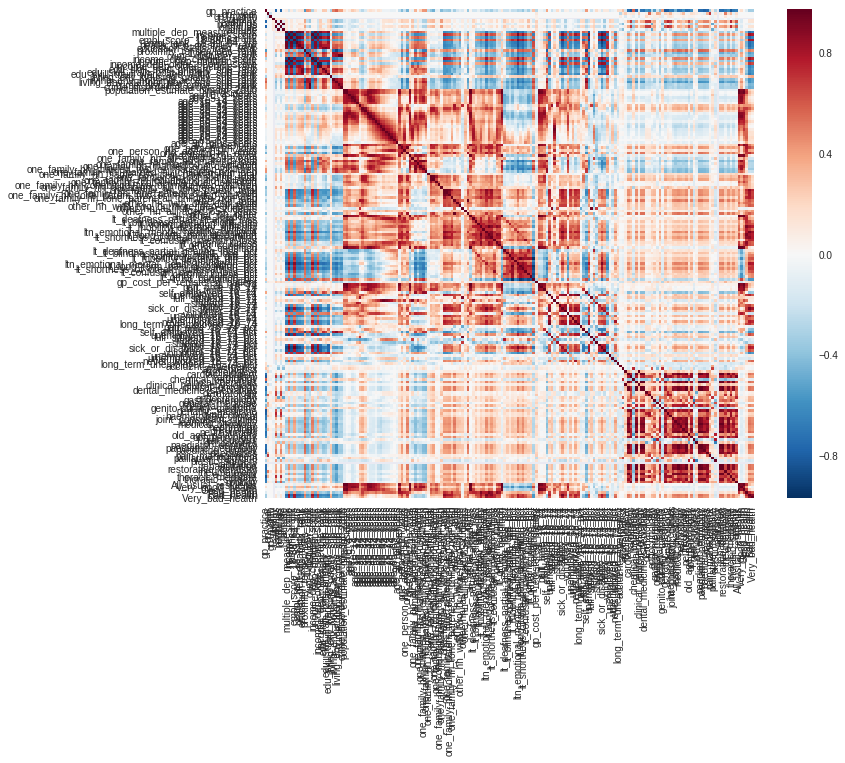

In [30]:
# Create a correlation matrix for the training dataset. 
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

In [31]:
# Replace the missing values with "None" for the categorical columns. 
missing_data_list = missing_data.index.tolist()
missing_cat_data_list = [col for col in missing_data_list if all_data[col].dtype == 'O']
for col in missing_cat_data_list:
    all_data[col] = all_data[col].fillna("None")

In [32]:
# Get a list of all the numeric columns containing missing values. 
missing_num_data_list = [col for col in missing_data_list if all_data[col].dtype == 'float64']

In [33]:
# Separate the values within the missing numeric columns list into separate lists concerning the
# original training datasets.
missing_starter_num_data_list = [col for col in missing_num_data_list if col in starter_data.columns]
missing_employment_num_data_list = [col for col in missing_num_data_list if col in employment_data.columns]
missing_waiting_num_data_list = [col for col in missing_num_data_list if col in waiting_data.columns]
missing_health_num_data_list = [col for col in missing_num_data_list if col in health_data.columns]

In [34]:
# Now to systematically replace the missing values within the numeric columns with median column values. 
# These median values will be grouped by the common columns determined earlier.
for col in missing_starter_num_data_list:
    all_data[col] = all_data[col].transform(lambda x: x.fillna(x.median()))

In [35]:
for col in missing_employment_num_data_list:
    all_data[col] = all_data.groupby(['soa'])[col].transform(lambda x: x.fillna(x.median()))

In [36]:
for col in missing_health_num_data_list:
    all_data[col] = all_data.groupby(['soa'])[col].transform(lambda x: x.fillna(x.median()))

In [37]:
for col in missing_waiting_num_data_list:
    all_data[col] = all_data.groupby(['hsc_trust', 'gp_month', 'gp_year'])[col].transform(lambda x: x.fillna(x.median()))

In [38]:
for col in missing_waiting_num_data_list:
    all_data[col] = all_data.groupby(['gp_month', 'gp_year'])[col].transform(lambda x: x.fillna(x.median()))

In [39]:
for col in missing_waiting_num_data_list:
    all_data[col] = all_data.groupby(['gp_year'])[col].transform(lambda x: x.fillna(x.median()))

In [40]:
for col in missing_num_data_list:
    all_data[col] = all_data[col].transform(lambda x: x.fillna(x.median()))

In [41]:
#Check if there is any remaining missing values within the training and testing datasets. 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


# Check for Skewness:

In [42]:
# Convert numeric columns with less than 15 unique values to categorical variables. 
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
num_to_cat_columns = [col for col in numeric_feats if len(set(all_data[col])) < 15]
for col in num_to_cat_columns:
    all_data[col] = all_data[col].apply(str)

In [43]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Compute the skewness of all the numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
full_student_16_74_pct,9.683578
full_student_16_74,8.379101
plastic_surgery,4.760678
genito-urinary_medicine,4.686252
thoracic_surgery,4.468954
student_16_74_pct,4.397533
joint_consultant_clinics,4.184609
age_20_24_years,4.037964
paediatric_surgery,3.906245
medical_oncology,3.879447


In [44]:
# If the absolute skewness value for the numeric column is greater than 0.75 it will be Box-Cox transformed.
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index.tolist()
# Remove 'longitude' variable from skewed_features dataset as it return extra NaN values. 
del skewed_features[skewed_features.index('longitude')]
# Lambda value of 0.15:
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 170 skewed numerical features to Box Cox transform


In [45]:
# Use pandas get_dummies function to convert the categorical variables into dummy variables. 
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(10076, 926)


In [46]:
# Finally seperate the all_data dataset back into the training and testing datasets. 
train = all_data[:ntrain]
test = all_data[ntrain:]

# Predictive Model Stage:

In [47]:
#Validation function
n_folds = 5

# Create MSE function to be used for evaluation of the machine learning models. 
def mse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    mse= -cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf)
    return(mse)

In [48]:
# Construct a Pipeline from the Lasso estimator.
# Using the RobustScaler() function scales the features using statistics that are robust to outliers.
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [49]:
# Construct a Pipeline from the ElasticNet estimator.
# Using the RobustScaler() function scales the features using statistics that are robust to outliers.
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [50]:
# Define a KernelRidge estimator.
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [51]:
# Define a GradientBoostingRegressor estimator.
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.06,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=13, min_samples_split=17, 
                                   loss='huber', random_state =5)

In [52]:
# Define a XGBRegressor estimator.
model_xgb = xgb.XGBRegressor(colsample_bytree=0.3210, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.8105, reg_lambda=0.9052,
                             subsample=0.14736, silent=1, nthread = -1)

In [53]:
# Define a LGBMRegressor estimator.
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=6,
                              learning_rate=0.04, n_estimators=720,
                              max_bin = 49, bagging_fraction = 0.17,
                              bagging_freq = 8, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =9, min_sum_hessian_in_leaf = 11)

In [54]:
mse_score = mse_cv(lasso)
print("\nLasso MSE score: {:.4f} ({:.4f})\n".format(mse_score.mean(), mse_score.std()))

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.


Lasso MSE score: 10.8044 (4.3156)



/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [55]:
mse_score = mse_cv(ENet)
print("ElasticNet MSE score: {:.4f} ({:.4f})\n".format(mse_score.mean(), mse_score.std()))

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.

ElasticNet MSE score: 11.5321 (5.4177)



/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [56]:
mse_score = mse_cv(KRR)
print("Kernel Ridge MSE score: {:.4f} ({:.4f})\n".format(mse_score.mean(), mse_score.std()))

Kernel Ridge MSE score: 8.7859 (4.1097)



In [57]:
mse_score = mse_cv(GBoost)
print("Gradient Boosting MSE score: {:.4f} ({:.4f})\n".format(mse_score.mean(), mse_score.std()))

Gradient Boosting MSE score: 8.8882 (6.4418)



In [58]:
mse_score = mse_cv(model_xgb)
print("Xgboost MSE score: {:.4f} ({:.4f})\n".format(mse_score.mean(), mse_score.std()))

Xgboost MSE score: 8.2309 (5.7042)



In [59]:
mse_score = mse_cv(model_lgb)
print("LGBM MSE score: {:.4f} ({:.4f})\n" .format(mse_score.mean(), mse_score.std()))

LGBM MSE score: 7.9026 (4.9050)



# Sklearn Stacked Ensemble:

In [60]:
# BaseEstimator object - Base class for all estimators in scikit-learn.
# RegressorMixin object - Mixin class for all regression estimators in scikit-learn.
# TransformerMixin object - Mixin class for all transformers in scikit-learn..

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        '''
        base_models: A list of base models that will be stacked. 
        meta_model: A single model that will be used to stack the base models. 
        n_folds: The number of folds to be used in cross-validation. 
        '''
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        
        # Define a holder for the base_models. 
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        
        # Define a KFold object used to determine the CV fold indexes. 
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Define a container for the predictions of each of the base models. 
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Train the meta-model on the out-of-fold predictions of the base models for the training dataset.
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # Now use the trained meta model to predict the output using the predictions of the base models for 
    # the test dataset.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [61]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

mse_score = mse_cv(stacked_averaged_models)
print("Stacking Averaged models MSE score: {:.4f} ({:.4f})".format(mse_score.mean(), mse_score.std()))

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.

Stacking Averaged models MSE score: 8.4120 (5.0851)


In [62]:
def mse(y, y_pred):
    return mean_squared_error(y, y_pred)

In [63]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = stacked_averaged_models.predict(test.values)
print(mse(y_train, stacked_train_pred))

/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/mark/anaconda3/envs/python35/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.

1.00241280978


In [64]:
# sub = pd.DataFrame()
# sub['record_id'] = test_ID
# sub['prediction'] = stacked_pred
# sub.to_csv('stacked_submission.csv',index=False)

In [65]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = model_xgb.predict(test)
print(mse(y_train, xgb_train_pred))

1.02885999563


In [66]:
# sub = pd.DataFrame()
# sub['record_id'] = test_ID
# sub['prediction'] = xgb_pred
# sub.to_csv('xgb_submission.csv',index=False)

In [67]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = model_lgb.predict(test.values)
print(mse(y_train, lgb_train_pred))

1.9934452998


In [68]:
# sub = pd.DataFrame()
# sub['record_id'] = test_ID
# sub['prediction'] = lgb_pred
# sub.to_csv('lgb_submission.csv',index=False)

# Creating Final Predictions:

In [69]:
predistions_df = pd.DataFrame({
    'stacked':stacked_train_pred,
    'xgb':xgb_train_pred,
    'lgb':lgb_train_pred
})

In [70]:
reg = linear_model.LinearRegression()
reg.fit (predistions_df.values, y_train)
coefs = reg.coef_

In [71]:
print('MSE score on train data:')
print(mse(y_train,stacked_train_pred*coefs[0] +
               xgb_train_pred*coefs[1] + lgb_train_pred*coefs[2]))

MSE score on train data:
1.94231928389


In [72]:
test_predistions_df = pd.DataFrame({
    'stacked':stacked_pred,
    'xgb':xgb_pred,
    'lgb':lgb_pred
})

In [73]:
ensemble = stacked_pred*coefs[0] + xgb_pred*coefs[1] + lgb_pred*coefs[2]

In [74]:
sub = pd.DataFrame()
sub['record_id'] = test_ID
sub['prediction'] = ensemble
sub.to_csv('lin_reg_sub.csv',index=False)

In [75]:
model_xgb = xgb.XGBRegressor(gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.8105, reg_lambda=0.9052,
                             subsample=0.14736, silent=1, nthread = -1)

In [76]:
model_xgb.fit(predistions_df, y_train)
xgb_train_pred_ensemble = model_xgb.predict(predistions_df)
xgb_pred_ensemble = model_xgb.predict(test_predistions_df)
print(mse(y_train, xgb_train_pred_ensemble))

0.587738957129


In [77]:
sub = pd.DataFrame()
sub['record_id'] = test_ID
sub['prediction'] = xgb_pred_ensemble
sub.to_csv('final_sub.csv',index=False)